# Import libraries

In [ ]:
# Install the OpenSlide C library and Python bindings
# After installing these libraries, use `Runtime -> restart and run all` on the menu
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libopenslide0
Suggested packages:
  libtiff-tools
The following NEW packages will be installed:
  libopenslide0 openslide-tools
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 92.5 kB of archives.
After this operation, 268 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libopenslide0 amd64 3.4.1+dfsg-2 [79.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 openslide-tools amd64 3.4.1+dfsg-2 [12.7 kB]
Fetched 92.5 kB in 1s (135 kB/s)
Selecting previously unselected package libopenslide0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../libopenslide0_3.4.1+dfsg-2

In [ ]:
!pip install patchify

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import tensorflow as tf
import pathlib
import random
import IPython.display as display


AUTOTUNE = tf.data.experimental.AUTOTUNE
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow import keras

from patchify import patchify
import cv2
import matplotlib.ticker as plticker
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Perform inference

In [ ]:
def download(slide_path, tumor_mask_path):
  slide_url = 'https://storage.googleapis.com/columbia_applied_dl/%s' % slide_path
  mask_url = 'https://storage.googleapis.com/columbia_applied_dl/%s' % tumor_mask_path

  # Download the whole slide image
  if not os.path.exists(slide_path):
    !curl -O $slide_url

  # Download the tumor mask
  if not os.path.exists(tumor_mask_path):
    !curl -O $mask_url


In [ ]:
def describe_slide(slide_path, tumor_mask_path):
  slide = open_slide(slide_path)
  print("Read WSI from %s with width: %d, height: %d" % (slide_path, 
                                                        slide.level_dimensions[0][0], # width
                                                        slide.level_dimensions[0][1])) # height

  tumor_mask = open_slide(tumor_mask_path)
  print("Read tumor mask from %s" % (tumor_mask_path))

  print("Slide includes %d levels" % len(slide.level_dimensions))
  for i in range(len(slide.level_dimensions)):
    print("Level %d, dimensions: %s downsample factor %d" % (i, 
                                                             slide.level_dimensions[i], 
                                                             slide.level_downsamples[i]))
  print()
  
  # Verify downsampling works as expected
  width, height = slide.level_dimensions[7]
  assert width * slide.level_downsamples[7] == slide.level_dimensions[0][0]
  assert height * slide.level_downsamples[7] == slide.level_dimensions[0][1]

In [ ]:
# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    # (x, y) tuple giving the top left pixel in the level 0 reference frame
    im = im.convert('RGB') # drop the alpha channel (alpha indicates how opaque each pixel is)
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

In [ ]:
def plot_slide(idx, level):

  #slide_path = 'tumor_'+ idx +'.tif' 

  slide = slides[idx]

  #slide = open_slide(slide_path)

  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])
  
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide_image)
  return slide_image

In [ ]:
def plot_mask(idx, level):

  #tumor_mask_path = 'tumor_'+ idx +'_mask.tif'

  tumor_mask = masks[idx]

  #tumor_mask = open_slide(tumor_mask_path)  

  mask_image = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=tumor_mask.level_dimensions[level][0], 
                        height=tumor_mask.level_dimensions[level][1])[:,:,0]

  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(mask_image)
  return mask_image

In [ ]:
def plot_overlay(slide, mask):
  plt.figure(figsize=(10,10), dpi=100)
  plt.imshow(slide)
  plt.imshow(mask, cmap='jet', alpha=0.5) # Red regions contains cancer.

In [ ]:
def load_model():

  data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2)])

  global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
  prediction_layer = tf.keras.layers.Dense(1)
  preprocess_input = tf.keras.applications.inception_v3.preprocess_input

  base_model = tf.keras.applications.inception_v3.InceptionV3(input_shape=(299,299,3),
                                               include_top=False,
                                               weights='imagenet')
  
  
  inputs = tf.keras.Input(shape=(299, 299, 3))
  x = data_augmentation(inputs)
  x = preprocess_input(x)
  x = base_model(x, training=False)
  x = global_average_layer(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs)
  #base_model.trainable = False

  base_model.trainable = True
  # Fine-tune from this layer onwards
  fine_tune_at = 200

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  opt = keras.optimizers.Adam(learning_rate=0.00005/10)

  model.compile(optimizer=opt,
                loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
def load_slide(idx, level):

  slide = slides[idx]  
  slide_image_1 = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=level, 
                         width=slide.level_dimensions[level][0], 
                         height=slide.level_dimensions[level][1])

  return slide_image_1

In [ ]:
def load_mask(idx, level):

  tumor_mask = masks[idx]
  mask_image_1 = read_slide(tumor_mask, 
                        x=0, 
                        y=0, 
                        level=level, 
                        width=slide.level_dimensions[level][0], 
                        height=slide.level_dimensions[level][1])[:,:,0]

                        # create a mask with all zeros that will later be filled with predictions - level 2

  return mask_image_1

In [ ]:
def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image) # convert an RGB image into grayscale. pixel values changed from (0,255) to (0,1)
    # Gray level images use a single value per pixel that is called intensity or brightness. 0 is black, 255 is white.
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity) # Return the indices of the elements that are non-zero or True.
    return list(zip(indices[0], indices[1]))

In [ ]:
def predict(model, slide_image_lv, level):

  patches_img = patchify(slide_image_lv, (299, 299, 3), step=299)  #Step=299 for 299 patches means no overlap

  single_mask_img = np.zeros((patches_img.shape[0],patches_img.shape[1]))

  for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
      single_patch_img = patches_img[i,j,0,:,:,:]
      tissue_pixels = find_tissue_pixels(single_patch_img)
      percent_tissue = len(tissue_pixels) / float(single_patch_img.shape[0] * single_patch_img.shape[1])
      if percent_tissue >= 0.2:
        single_patch_img = np.expand_dims(single_patch_img, axis=0)
        preds = model.predict(single_patch_img, verbose=0)
        predictions = tf.nn.sigmoid(preds)
        pred_label = tf.where(predictions < 0.5, 0, 1)
        single_mask_img[i,j] = pred_label
    
  
  # get the index pairs / (x,y) coordinates that belong to the positive class

  indices = np.where(single_mask_img == 1)
  idx_pair = list(zip(indices[0], indices[1]))

  # create a block of 1s, same size as each patch: (299,299)
  block = np.ones((299,299))
  
  # initiate prediction array to be all zeros
  pred_1 = np.zeros((slide_image_lv.shape[0], slide_image_lv.shape[1]))

  # loop over all pairs of positive indices at level 2
  for idx in idx_pair:
    x = idx[0] * 299
    y = idx[1] * 299
    pred_1[x:x+block.shape[0], y:y+block.shape[1]] = block

  return pred_1

In [ ]:
def downsize(pred_1, level):
  # Downside a heatmap from level 1 to level 5 for visualization
  height, width = pred_1.shape

  d = 5 - level # difference between the current level and level 5
  N = pow(2,d) # from level 1 to 5, N = 16

  heatmap = np.average(np.split(np.average(np.split(pred_1, width // N, axis=1), axis=-1), height // N, axis=1), axis=-1)

  return heatmap

In [ ]:
def create_heatmap(idx, level, model):

  slide_image_1 = load_slide(idx, level)

  pred_1 = predict(model=model, slide_image_1=slide_image_1, level=level)

  heatmap = downsize(pred_1, level)

  return heatmap

In [ ]:
def create_cm(heatmap, mask_image):
  heatmap_cm = heatmap.flatten().astype(np.uint8)
  mask_image_cm = mask_image.flatten()

  print("***** Test Data Analysis *****")
  #print("Accuracy on Test Set : {:0.4f}".format(accuracy))
  prfs = precision_recall_fscore_support(mask_image_cm, heatmap_cm, average = 'macro')
  print("Precision : ", prfs[0])
  print("Recall : ", prfs[1])
  print("F1 Score : ", prfs[2])

  m = tf.keras.metrics.MeanIoU(num_classes=2)
  m.update_state(mask_image_cm, heatmap_cm)
  print(f"Mean Intersection-Over-Union (IOU): {m.result().numpy()}")
  m.reset_state()

  cf = confusion_matrix(mask_image_cm, heatmap_cm)

  print("-"*30)
  print('True Negatives: ', cf[0][0])
  print('False Positives: ', cf[0][1])
  print('False Negatives: ', cf[1][0])
  print('True Positives: ', cf[1][1])
  print('Total: ', np.sum(cf[1]))
  print()

  sns.heatmap(cf, annot = True, fmt = 'd')
  plt.title("Confusion Matrix for Test Set")
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.show()

In [ ]:
# The slides for inference are not in the training set.
indices = ['110','091','075'] # 101, 094 and 064, 078 are too large

slides = []
masks = []

for slide in indices:

  slide_path = 'tumor_'+ slide +'.tif' 
  tumor_mask_path = 'tumor_'+ slide +'_mask.tif'

  download(slide_path, tumor_mask_path)
  print()

  describe_slide(slide_path, tumor_mask_path)

  slides.append(open_slide(slide_path))
  masks.append(open_slide(tumor_mask_path))

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1416M  100 1416M    0     0   245M      0  0:00:05  0:00:05 --:--:--  263M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31.3M  100 31.3M    0     0  86.0M      0 --:--:-- --:--:-- --:--:-- 86.2M

Read WSI from tumor_110.tif with width: 94208, height: 71680
Read tumor mask from tumor_110_mask.tif
Slide includes 9 levels
Level 0, dimensions: (94208, 71680) downsample factor 1
Level 1, dimensions: (47104, 35840) downsample factor 2
Level 2, dimensions: (23552, 17920) downsample factor 4
Level 3, dimensions: (11776, 8960) downsample factor 8
Level 4, dimensions: (5888, 4480) downsample factor 16
Level 5, dimensions: (2944, 2240) downsample factor 32
Level 6, dimensions: (1472, 1120) downsample factor 64
Level 7, dim

In [ ]:
model = load_model()
model.load_weights("finetuned_weights_dec14.h5")
model.summary()

87910968/87910968 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 299, 299, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 299, 299, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 299, 299, 3)      0         
 a)                                                              
                                                                 
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                              

In [ ]:
#slide_image_lv = load_slide(idx=0, level=1)

In [ ]:
#pred = predict(model=model, slide_image_lv=slide_image_lv, level=1)

In [ ]:
#heatmap = downsize(pred, level=1)

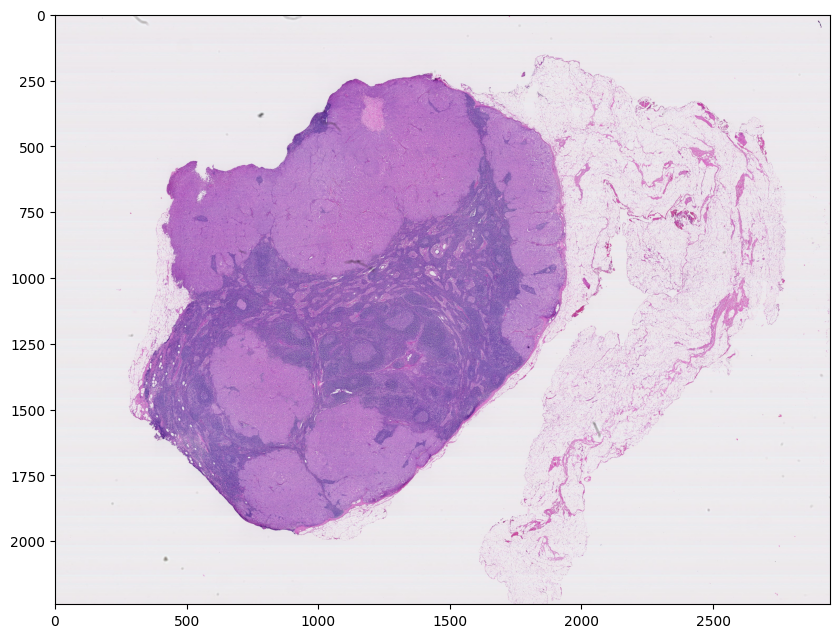

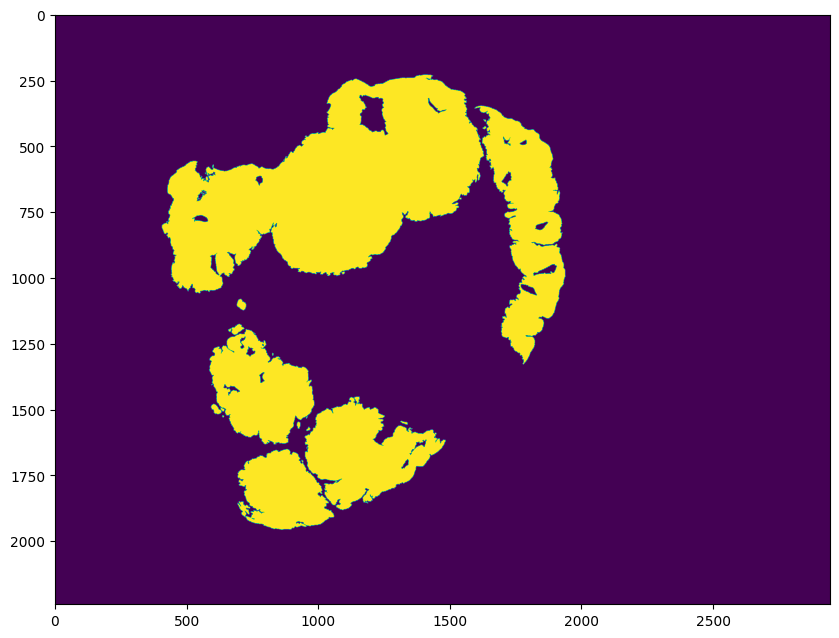

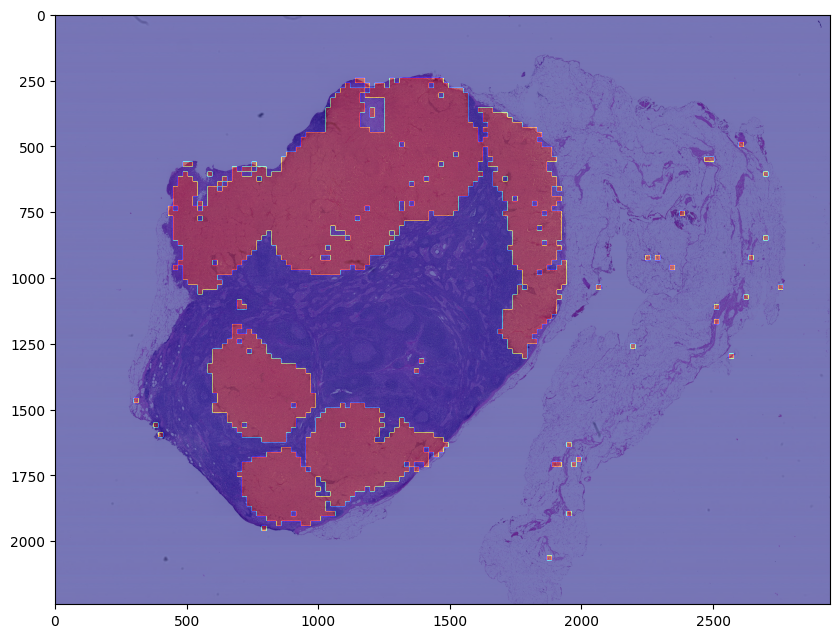

In [ ]:
heatmap = create_heatmap(idx=0, level=1, model=model)

slide_image  = plot_slide(idx=0, level=5) # slide
mask_image = plot_mask(idx=0,level=5) # ground truth

plot_overlay(slide_image, heatmap) # heatmap


***** Test Data Analysis *****
Precision :  0.9645519626900404
Recall :  0.9519230309263721
F1 Score :  0.9581013635337943
Mean Intersection-Over-Union (IOU): 0.9210660457611084
------------------------------
True Negatives:  5511773
False Positives:  54722
False Negatives:  88746
True Positives:  939319
Total:  1028065



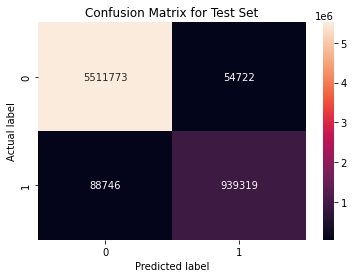

In [ ]:
# idx = 0
create_cm(heatmap, mask_image) # create confusion matrix & IOU

In [ ]:
#slide_image_lv = load_slide(idx=2, level=1)

In [ ]:
#pred = predict(model=model, slide_image_lv=slide_image_lv, level=1)

In [ ]:
#heatmap = downsize(pred, level=1)

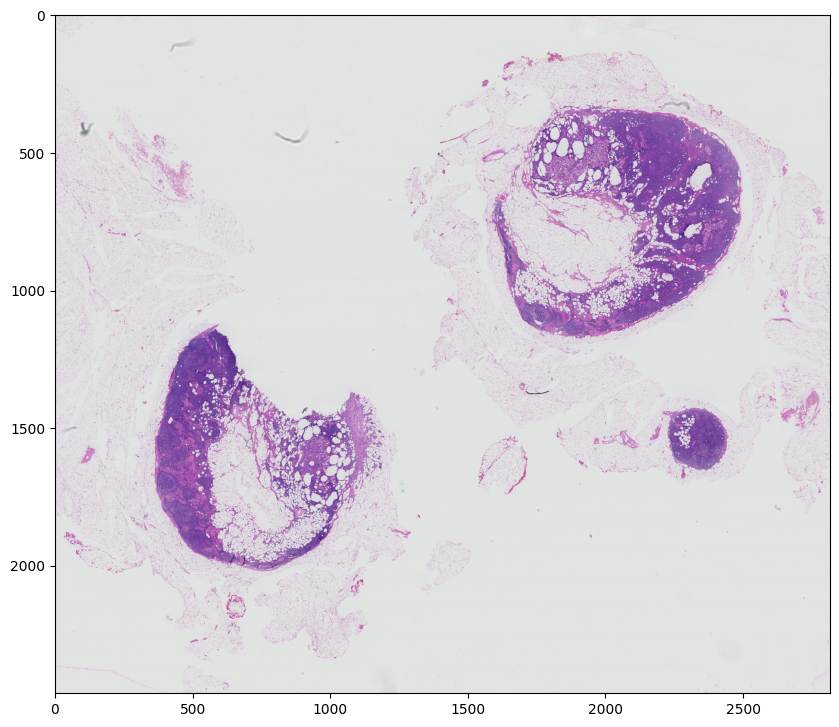

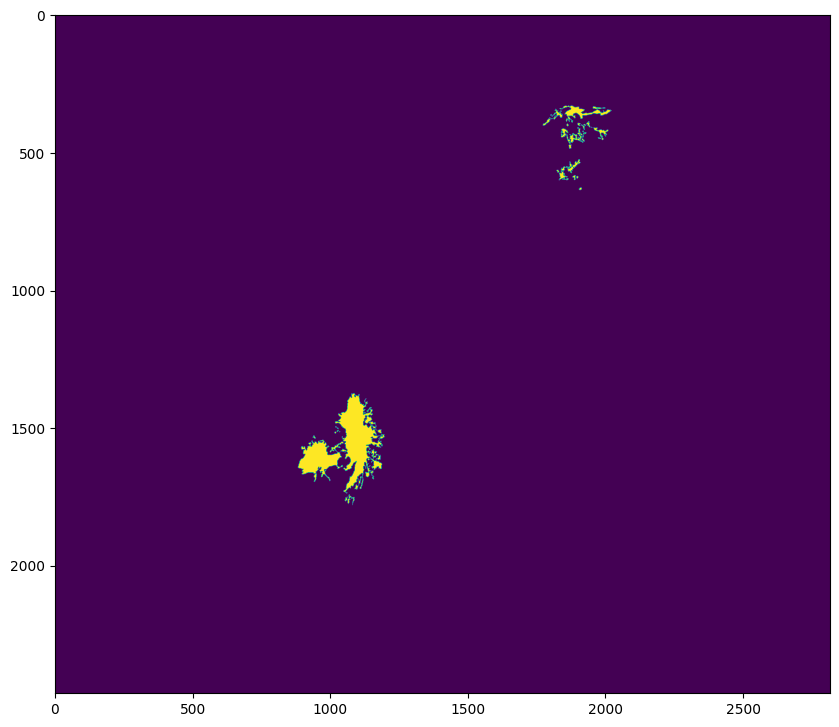

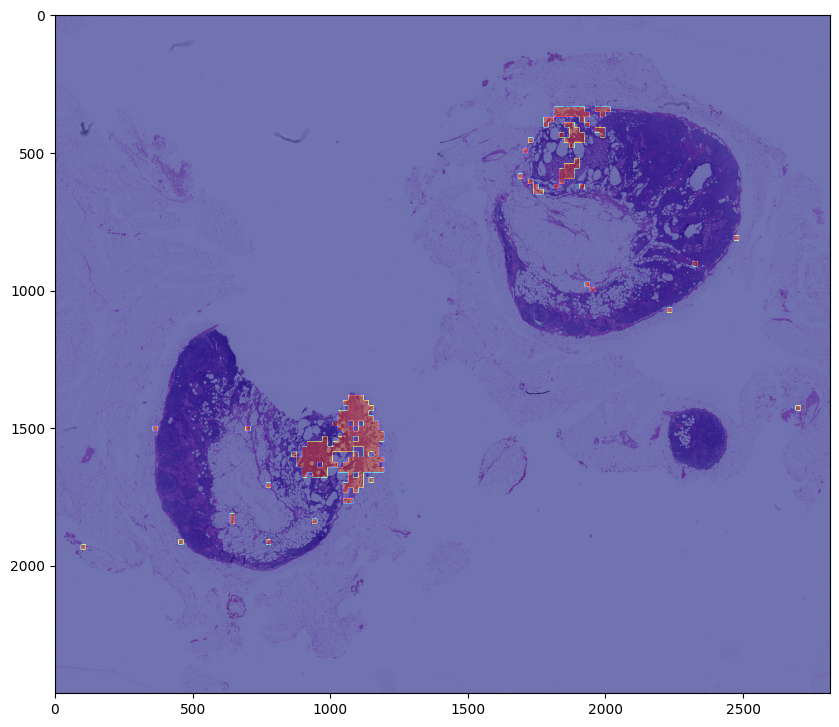

In [ ]:
heatmap = create_heatmap(idx=2, level=1, model=model)

slide_image  = plot_slide(idx=2, level=5) # slide
mask_image = plot_mask(idx=2,level=5) # ground truth

plot_overlay(slide_image, heatmap) # heatmap

***** Test Data Analysis *****
Precision :  0.7547544508074064
Recall :  0.9073783230916039
F1 Score :  0.8130821990134278
Mean Intersection-Over-Union (IOU): 0.726343035697937
------------------------------
True Negatives:  6854153
False Positives:  37165
False Negatives:  8508
True Positives:  38798
Total:  47306



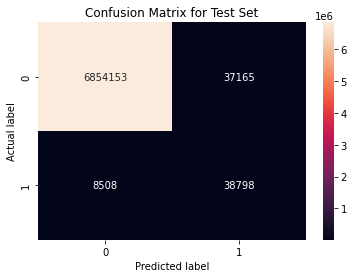

In [ ]:
# idx = 2
create_cm(heatmap, mask_image) # create confusion matrix & IOU

In [ ]:
#slide_image_lv = load_slide(idx=1, level=1)

In [ ]:
#pred = predict(model=model, slide_image_lv=slide_image_lv, level=1)

In [ ]:
#heatmap = downsize(pred, level=1)

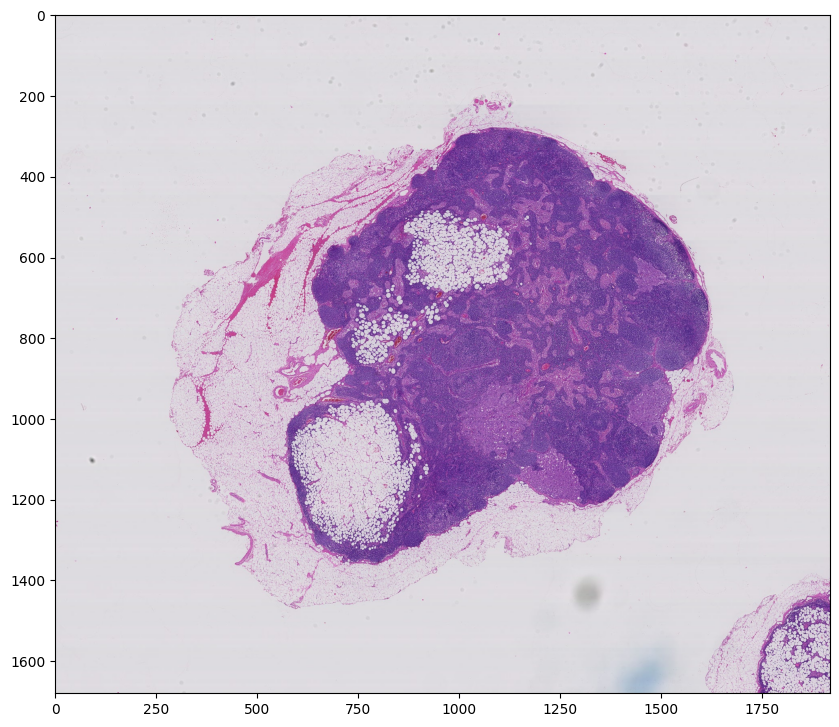

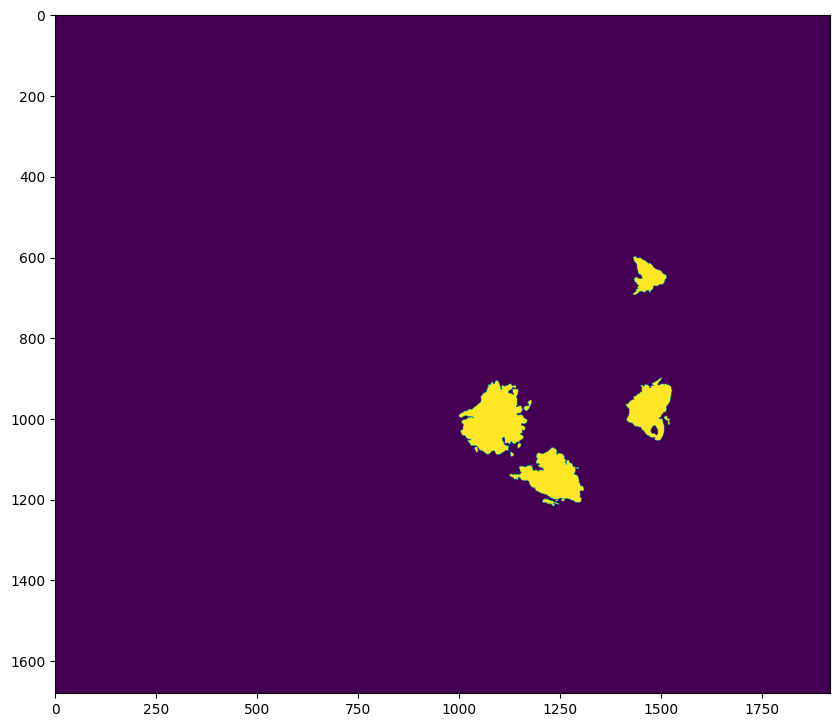

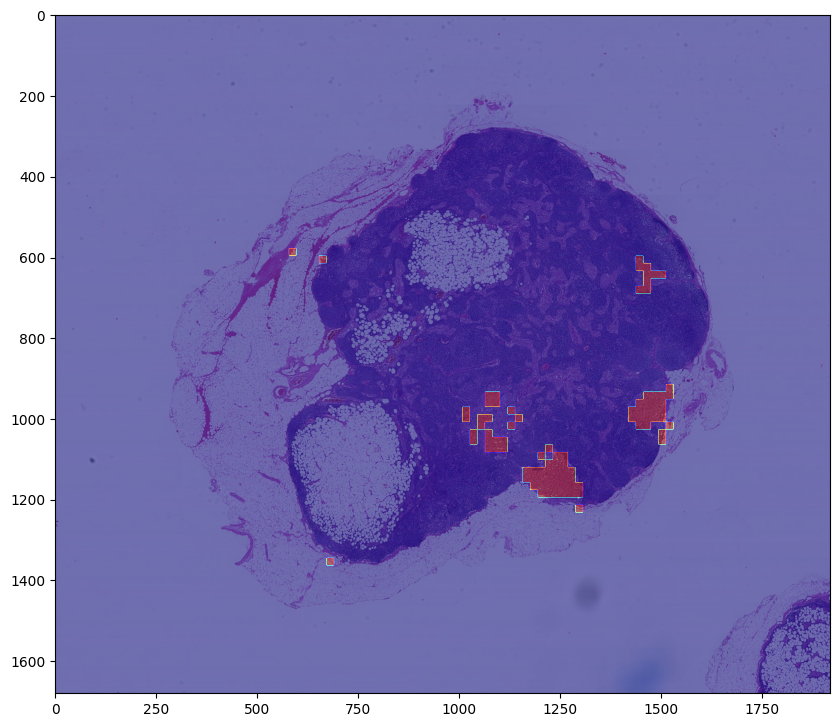

In [ ]:
heatmap = create_heatmap(idx=1, level=1, model=model)

slide_image  = plot_slide(idx=1, level=5) # slide
mask_image = plot_mask(idx=1,level=5) # ground truth

plot_overlay(slide_image, heatmap) # heatmap

***** Test Data Analysis *****
Precision :  0.9210637400788375
Recall :  0.778858560526559
F1 Score :  0.8350853788427366
Mean Intersection-Over-Union (IOU): 0.7502754926681519
------------------------------
True Negatives:  3174183
False Positives:  4665
False Negatives:  20609
True Positives:  26143
Total:  46752



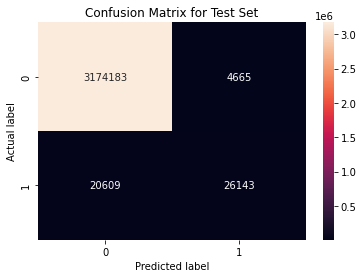

In [ ]:
# idx = 1
create_cm(heatmap, mask_image) # create confusion matrix